# Custom Technology

In this tutorial, we'll look at creating your own custom technology or PDK for your fabrication process.

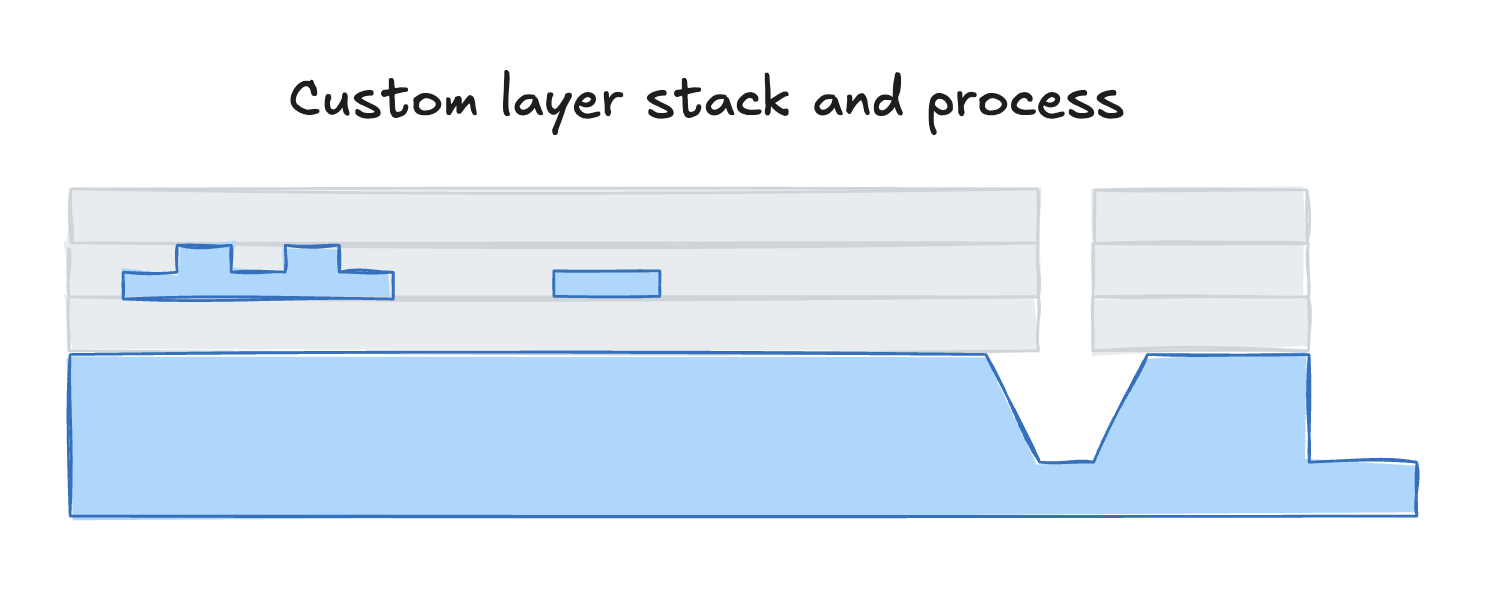

The [Technology](Technology.ipynb) guide explains the main attributes required to define any technology in PhotonForge.
Typically, this process can be split in 3 main steps:

1. Defining the layers used to classify whether a shape is a waveguide, a metal interconnect, a cut-out region, and so on;
1. Specifying how those layers are combined into masks and extruded into 3D structures with specific material properties; and
1. Optionally, defining the default waveguide cross-sections used as ports in the PDK. 

For this demonstration, we will build a simple technology for thin-film lithium niobate (TFLN) photonics platform, which utilizes LiNbO₃ on insulator (LNOI) wafers similar to silicon-on-insulator (SOI) ones used in silicon photonics.

For this PDK, we assume 500 nm of active TFLN with an etch depth of 260 nm to form rib waveguides.
The etch process produces profiles with 20° sidewalls relative to the wafer normal.
The SiO₂ top cladding has thickness of 1 μm and the buried oxide (BOX) is 4.7 μm thick.

Because LiNbO₃ is an anisotropic meidum, we will use ordinary and extraordinary indices of 2.169 and 2.234, respectively, and we will assume that the oxide has refractive index of 1.46.

We'll define one type of port corresponding to a single mode rib waveguide with 800 nm core width.

In [1]:
import photonforge as pf
import tidy3d as td
import numpy as np

## Defining the layers

We will have 3 layers:

- A waveguide layer "WG" using layer number (1, 1) that indicates regions where the LiNbO₃ should not be etched.
- A full full etch layer "CLEAR" at (1, 2), indicating regions where the LiNbO₃ should be completely removed.
- An access layer "OPEN" at (2, 0), where we partially remove the top oxide cladding to access the LiNbO₃ layer.

All regions of the device that are not part of the "WG" or "CLEAR" layers will be left with a LiNbO₃ slab after the partial etch of 260 nm.

The dictionary can be rendered as a table with proper coloring using the [LayerTable](../_autosummary/photonforge.LayerTable.rst) utility class.
Other visualization helpers we will use are [ExtrusionTable](../_autosummary/photonforge.ExtrusionTable.rst) and [PortSpecTable](../_autosummary/photonforge.PortSpecTable.rst).

In [2]:
layers = {
    "WG": pf.LayerSpec(
        (1, 1), description="Full-thickness LiNbO₃ core", color="#a0b00018", pattern="/"
    ),
    "CLEAR": pf.LayerSpec(
        (1, 2), description="Full LiNbO₃ removal", color="#90205018", pattern="x"
    ),
    "OPEN": pf.LayerSpec(
        (2, 0), description="Top cladding removal", color="#3050a018", pattern=":"
    ),
}

pf.LayerTable(layers)

Name  Layer          Description            Color    Pattern
-------------------------------------------------------------
CLEAR  (1, 2)  Full LiNbO₃ removal         #90205018     x   
OPEN   (2, 0)  Top cladding removal        #3050a018     :   
WG     (1, 1)  Full-thickness LiNbO₃ core  #a0b00018     /

## Extrusion specifications

Next, we define the masks and extrusion rules that are used to generate 3D structures from the 2D shapes in the layout.
From our layer specification, we will need 3 masks.

The first we will use to extrude the full LiNbO₃ thickness in the "WG" regions.
Next, we will create a mask that is the inversion the "CLEAR" layer, which will be used to extrude the thinner slab.
Finally, the "OPEN" layer will be used to remove the top cladding.
Here we will assume that the etch process used to selectively remove the top oxide affects the sidewalls, so the resulting holes are slightly larger than the layout design.

In [3]:
# Simple mask for a single layer
wg_mask = pf.MaskSpec((1, 1))

# Inversion of the (1, 2) layer: note the minus sign before the spec
clear_mask = -pf.MaskSpec((1, 2))

# Single layer dilated by 200 nm (this is the same as pf.MaskSpec((2, 0)) ** 0.2
open_mask = pf.MaskSpec((2, 0), dilation=0.2)

We also need the media that we will use for extruded structures:

In [4]:
linbo3 = td.AnisotropicMedium(
    xx=td.Medium(permittivity=2.234**2),
    yy=td.Medium(permittivity=2.169**2),
    zz=td.Medium(permittivity=2.234**2),
)

sio2 = td.Medium(permittivity=1.46**2)

air = td.Medium(permittivity=1)

With the masks and media, we can define the extrusion rules.
Each extrusion specification includes the mask, the extrusion limits in the z axis, the medium used for the extruded structures and, optionally a sidewall angle.

Their order matter: structures generated by a latter rule will override previous ones.
For example, the slab generated by the second rule will override the structures generated by the first wherever they overlap.
Since they use the same material, in this case it does not matter for the final result.

Additionally, we will use SiO₂ as the domain background, so we don't need to extrude it explicitly.
We do not need to include the air above the top cladding or the wafer substrate beneath the BOX, because the 1 μm thickness above and the 4.7 μm below are enough to prevent the excited waveguide modes to interact with either interface.
Adding them would make all future simulations include the whole upper and lower cladding regions unnecessarily.

In [5]:
extrusion_specs = [
    # The waveguide and slab extrusion layers implement the 20° sidewall angle (the reference mask
    # is used for at the upper limit and dilated at the lower with a positive angle)
    pf.ExtrusionSpec(wg_mask, limits=(0, 0.5), medium=linbo3, sidewall_angle=20),
    pf.ExtrusionSpec(
        clear_mask, limits=(0, 0.5 - 0.26), medium=linbo3, sidewall_angle=20
    ),
    # The clad removal opens up to "air", an unbounded region
    pf.ExtrusionSpec(open_mask, limits=(0.5, pf.Z_INF), medium=air),
]

pf.ExtrusionTable(extrusion_specs)

#      Mask     Limits (μm)  Sidewal (°)            Opt. Medium                       Elec. Medium          
------------------------------------------------------------------------------------------------------------
0  (1, 1)          0, 0.5         20      AnisotropicMedium(xx={'attrs': …  AnisotropicMedium(xx={'attrs': …
1  () - (1, 2)    0, 0.24         20      AnisotropicMedium(xx={'attrs': …  AnisotropicMedium(xx={'attrs': …
2  (2, 0)**0.2    0.5, inf        0       Medium(permittivity=1.0)          Medium(permittivity=1.0)

## Default port definitions

The third major step is defining the default waveguide cross-sections our PDK uses, if any.

More information on port specifications can be found in the [Ports](Ports.ipynb) guide.
Here, it is worth mentioning that the process of defining ports is iterative and requires some experimentation to best describe the port dimensions (in-plane width and z limits) such that all desired modes are well-supported but the port specification is not unnecessarily large.

In [6]:
ports = {
    "Rib_800": pf.PortSpec(
        description="Rib waveguide, TE, 800 nm",
        width=4.5,
        limits=(-1, 0.5 + 1),
        num_modes=1,
        target_neff=2,
        path_profiles=[(0.8, 0, (1, 1))],
    )
}

pf.PortSpecTable(ports)

Name   Classification         Description         Width (μm)  Limits (μm)  Modes  Target n_eff  Path profiles (μm)  Voltage path  Current path
------------------------------------------------------------------------------------------------------------------------------------------------
Rib_800     optical      Rib waveguide, TE, 800 nm     4.5        -1, 1.5      1         2        (1, 1): 0.8

## Creating the technology

With all the pieces already set, putting together the technology is quite simple:

In [7]:
tech = pf.Technology(
    name="Custom TFLN PDK",
    version="1.0",
    layers=layers,
    extrusion_specs=extrusion_specs,
    ports=ports,
    background_medium=sio2,
)

tech

Name: Custom TFLN PDK
Version: 1.0

Layers:
 Name  Layer          Description            Color    Pattern
-------------------------------------------------------------
CLEAR  (1, 2)  Full LiNbO₃ removal         #90205018     x   
OPEN   (2, 0)  Top cladding removal        #3050a018     :   
WG     (1, 1)  Full-thickness LiNbO₃ core  #a0b00018     /   

Extrusion Specs:
#      Mask      Limits (μm)  Sidewal (°)            Opt. Medium                       Elec. Medium          
-------------------------------------------------------------------------------------------------------------
0  'WG'             0, 0.5         20      AnisotropicMedium(xx={'attrs': …  AnisotropicMedium(xx={'attrs': …
1  () - 'CLEAR'    0, 0.24         20      AnisotropicMedium(xx={'attrs': …  AnisotropicMedium(xx={'attrs': …
2  'OPEN'**0.2     0.5, inf        0       Medium(permittivity=1.0)          Medium(permittivity=1.0)        

Ports:
  Name   Classification         Description         Width (μm)  Limits (μm)  Modes  Target n_eff  Path profiles (μm)  Voltage path  Current path
------------------------------------------------------------------------------------------------------------------------------------------------
Rib_800     optical      Rib waveguide, TE, 800 nm     4.5        -1, 1.5      1         2        'WG': 0.8                                     

Background medium:
- Optical: Medium(permittivity=2.1315999999999997)
- Electrical: Medium(permittivity=2.1315999999999997)

Connections: []

We test the extrusion profile with a simple test component:

In [8]:
test_component = pf.Component("test", technology=tech)

test_component.add(
    "WG",
    pf.Rectangle((0, -10), (2, 10)),
    pf.Rectangle((6, 0), (7, 10)),
    "CLEAR",
    pf.Rectangle((5, -10), (8, 10)),
    "OPEN",
    pf.Rectangle((-1, 0), (3, 10)),
)

test_component

In the `y=-5` cross-section we can see the "WG" and "CLEAR" layers in effect:

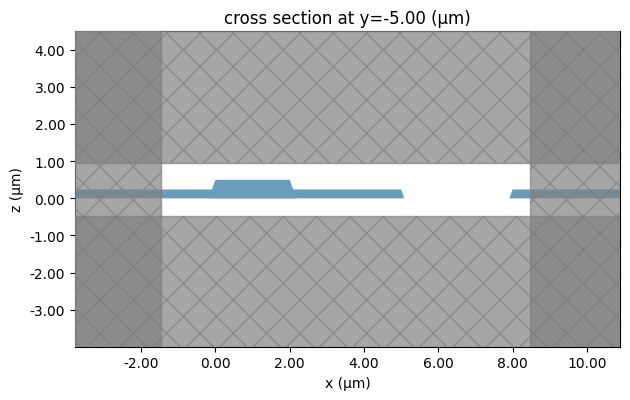

In [9]:
_ = pf.tidy3d_plot(test_component, y=-5)

In the `y=5` slice, we see both the resulting dilation of the "OPEN" extrusion, and what happens in the overlap between "WG" and "CLEAR":

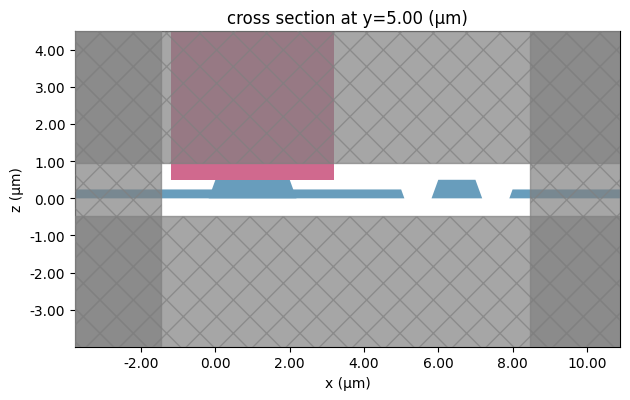

In [10]:
_ = pf.tidy3d_plot(test_component, y=5)

If that's not the desired result and we wanted the "CLEAR" rule to take precedence, we could, for example modify `wg_mask` to exclude any "CLEAR" regions.
Feel free to go back an try it out!

In [11]:
wg_mask_mod = pf.MaskSpec((1, 1), (1, 2), operation="-")

We can also test our port specification to make sure the mode is not touching the edges of the port:

Loading cached simulation from .tidy3d/pf_cache/G2Q/ms_info-XQRW33XMETIV64MPOJHSRE4MGTN756XWVV5MY7RMMNEMX5AEJVPA.json.


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  1.869524    0.0          0.994148   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.948276        0.885034   0.730002

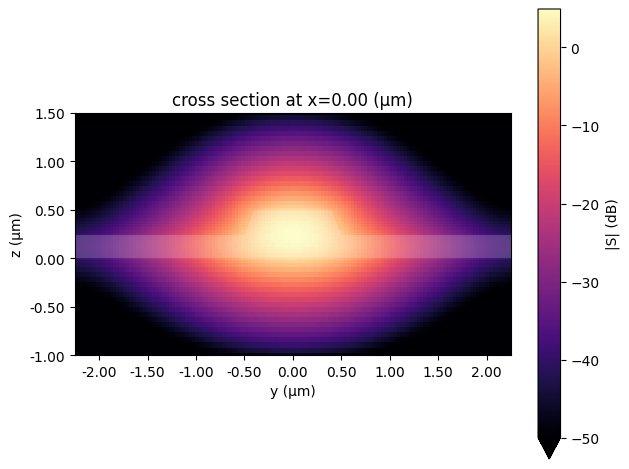

In [12]:
# We specify the technology here because we have not set it as the default
mode_solver = pf.port_modes("Rib_800",[pf.C_0 / 1.55], technology=tech)
mode_solver.plot_field(
    "S", val="abs", scale="dB", mode_index=0, f=pf.C_0 / 1.55, robust=False, vmin=-50
)
mode_solver.data.to_dataframe()

The plot uses a logarithmic scale with `robust` set to false so that we can evaluate the evanescent field intensity close to the port boundaries.
In this case, the peak Poynting vector intensity is almost at 5 dB, so we set the scale to a lower limit of -50 dB for a range of more than 50 dB in the color scale.

## Making it parametric

The best way to create a technology is to encapsulate it as a function, so that we can change the parameters later.
It is also a good idea to make it parametric using the [parametric_technology](../_autosummary/photonforge.parametric_technology.rst) decorator.
That way, we can update it later, for example, in the middle of Monte Carlo runs to test process variations, as shown in the [MZI example](../examples/Mach-Zehnder_Interferometer.ipynb).

In [13]:
@pf.parametric_technology
def custom_tfln_pdk(
    *,
    core_thickness=0.5,
    slab_etch_depth=0.26,
    sidewall_angle=20,
    linbo3=td.AnisotropicMedium(
        xx=td.Medium(permittivity=2.234**2),
        yy=td.Medium(permittivity=2.169**2),
        zz=td.Medium(permittivity=2.234**2),
    ),
    sio2=td.Medium(permittivity=1.46**2),
    air=td.Medium(permittivity=1)
):
    layers = {
        "WG": pf.LayerSpec(
            (1, 1),
            description="Full-thickness LiNbO₃ core",
            color="#a0b00018",
            pattern="/",
        ),
        "CLEAR": pf.LayerSpec(
            (1, 2), description="Full LiNbO₃ removal", color="#90205018", pattern="x"
        ),
        "OPEN": pf.LayerSpec(
            (2, 0), description="Top cladding removal", color="#3050a018", pattern=":"
        ),
    }

    wg_mask = pf.MaskSpec((1, 1))
    clear_mask = -pf.MaskSpec((1, 2))
    open_mask = pf.MaskSpec((2, 0), dilation=0.2)

    extrusion_specs = [
        pf.ExtrusionSpec(
            wg_mask,
            limits=(0, core_thickness),
            medium=linbo3,
            sidewall_angle=sidewall_angle,
        ),
        pf.ExtrusionSpec(
            clear_mask,
            limits=(0, core_thickness - slab_etch_depth),
            medium=linbo3,
            sidewall_angle=sidewall_angle,
        ),
        pf.ExtrusionSpec(open_mask, limits=(core_thickness, pf.Z_INF), medium=air),
    ]

    ports = {
        "Rib_800": pf.PortSpec(
            description="Rib waveguide, TE, 800 nm",
            width=4 + core_thickness,
            limits=(-1, core_thickness + 1),
            num_modes=1,
            target_neff=2,
            path_profiles=[(0.8, 0, (1, 1))],
        )
    }

    return pf.Technology(
        name="Custom TFLN PDK",
        version="1.0",
        layers=layers,
        extrusion_specs=extrusion_specs,
        ports=ports,
        background_medium=sio2,
    )

## Loading the technology

The parametric function should probably be placed in a separate Python file or package that can be imported from other scripts and notebooks.
Since we already have it defined here, we can just go ahead and use it:

In [14]:
tech = custom_tfln_pdk()
pf.config.default_technology = tech

We can inspect the layers and the ports that we defined earlier

In [15]:
tech.layers

Name  Layer          Description            Color    Pattern
-------------------------------------------------------------
CLEAR  (1, 2)  Full LiNbO₃ removal         #90205018     x   
OPEN   (2, 0)  Top cladding removal        #3050a018     :   
WG     (1, 1)  Full-thickness LiNbO₃ core  #a0b00018     /

In [16]:
tech.ports

Name   Classification         Description         Width (μm)  Limits (μm)  Modes  Target n_eff  Path profiles (μm)  Voltage path  Current path
------------------------------------------------------------------------------------------------------------------------------------------------
Rib_800     optical      Rib waveguide, TE, 800 nm     4.5        -1, 1.5      1         2        'WG': 0.8

Let's test an Euler bend with a 25 μm radius with a Tidy3D model to see how it performs:

In [17]:
euler_bend = pf.parametric.bend(port_spec="Rib_800", radius=25, euler_fraction=0.5, active_model="Tidy3D")
euler_bend

Loading cached simulation from .tidy3d/pf_cache/ZVX/fdtd_info-7H2NA7NBMIXC72LT33B2N7M3BHQ3C5B7QY33XPABEJCOOR5BUK7Q.json.


Progress: 100% 


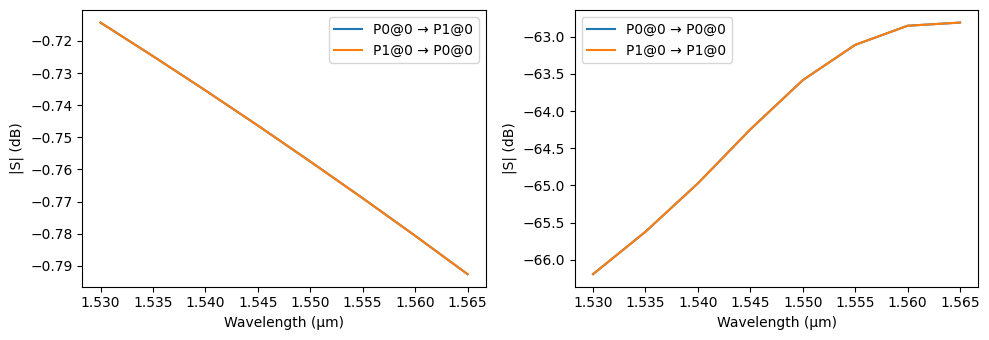

In [18]:
wavelengths = np.array(td.wavelengths.c_band())

s_matrix = euler_bend.s_matrix(pf.C_0 / wavelengths)

_ = pf.plot_s_matrix(s_matrix, y="dB")

Quite lossy, as expected for a tight bend in a rib waveguide.